<a href="https://colab.research.google.com/github/CoGian/Detection-of-toxic-comments-and-minimization-of-unintended-model-bias-using-neural-networks/blob/master/TextCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive' )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf 
import random
import pickle 
import gc
import os
from sklearn import metrics
from sklearn.model_selection import train_test_split
import sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
sys.path.append('/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/tools')
sys.path.append('/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification')
from tools_benchmark import  compute_bias_metrics_for_model, calculate_overall_auc,get_final_metric
from tools_load_data import get_datasets
from tools_evaluate_model import evaluate, plot_history_for_accuracy_and_loss

# TPU Configs

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.91.225.50:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.91.225.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.91.225.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
MODEL_NO = 2 
BATCH_SIZE = 512 
EPOCHS = 10

# Load Datasets

In [ ]:
 IDENTITY_COLUMNS  = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness'
  ] 

In [ ]:
train_df = pd.read_csv("/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/data/train_cleared.csv")
# train_df = train_df.sample(frac=0.1)
test_public_df = pd.read_csv("/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/data/test_public_cleared.csv")
# test_public_df = test_public_df.loc[:, ['toxicity','comment_text']  + IDENTITY_COLUMNS ].dropna()[:1000]
test_private_df = pd.read_csv("/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/data/test_private_cleared.csv")
# test_private_df = test_private_df.loc[:, ['toxicity', 'comment_text'] + IDENTITY_COLUMNS ].dropna()[:1000]

In [ ]:
# split 
train_df , val_df = train_test_split(train_df,test_size = 0.2 , random_state = 13 , shuffle = True)

In [ ]:
%%time 
train_dataset,validation_dataset, public_test_dataset, private_test_dataset , embedding_matrix = get_datasets(train_df, val_df, test_public_df, test_private_df)

In [ ]:
train_df_len = len(train_df)
del train_df
del val_df
gc.collect()

0

# Training and evaluation of models

In [ ]:
class CustomStopper(tf.keras.callbacks.EarlyStopping):
    def __init__(self, monitor='val_loss',
             min_delta=0, patience=0, verbose=0, mode='auto', start_epoch = 2 , restore_best_weights = True): # add argument for starting epoch
        super(CustomStopper, self).__init__(monitor=monitor,patience=patience,min_delta=min_delta,mode=mode, restore_best_weights = restore_best_weights)
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.start_epoch:
            super().on_epoch_end(epoch, logs)

In [ ]:
es = CustomStopper(start_epoch=2)

## Build model

In [ ]:
def create_TextCNN(embedding_matrix):
  words = tf.keras.Input(shape=(None,))
  x = tf.keras.layers.Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
  convs = []
  filter_sizes = [2,3,4,5,6]

  for filter_size in filter_sizes:
    l_conv = tf.keras.layers.Conv1D(filters=128, 
                        kernel_size=filter_size, 
                        activation='relu')(x)
    l_pool =tf.keras.layers.GlobalMaxPooling1D()(l_conv)
    convs.append(l_pool)
  
  l_merge = tf.concat(convs, axis=1) 
  x = tf.keras.layers.Dense(128, activation='relu')(l_merge)
  x = tf.keras.layers.Dropout(0.2)(x)
  result = tf.keras.layers.Dense(1, activation='sigmoid', name = 'target')(x)
  aux_result =  tf.keras.layers.Dense(6, activation='sigmoid', name = 'aux')(x)

  model = tf.keras.Model(inputs=words, outputs=[result, aux_result])
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

  return model 

## Train and tune the model

In [ ]:
def train():
  histories = [] 
  public_predictions = [] 
  private_predictions = [] 
  MODEL_NAME = "TextCNNBase" 
  print("\nTextCNNBase")
  PATH = 'TextCNN/' + MODEL_NAME
      
  for i in range(MODEL_NO):
    
    with strategy.scope():
      # create model 
      TextCNN = create_TextCNN(embedding_matrix)
    TextCNN.summary()
    n_steps = train_df_len // BATCH_SIZE 
    history = TextCNN.fit(x = train_dataset,validation_data=validation_dataset , callbacks=[es] , epochs = EPOCHS 
                          ,verbose = 1 , steps_per_epoch=n_steps)   
    histories.append(history)

    public_predictions.append(TextCNN.predict(public_test_dataset, verbose=1 )[0].flatten())
    private_predictions.append(TextCNN.predict(private_test_dataset, verbose=1 )[0].flatten())
    #save memmory 
    tf.tpu.experimental.initialize_tpu_system(tpu)

  y_public_pred = np.average(public_predictions, axis =0 )
  y_private_pred = np.average(private_predictions, axis= 0)
  # save its graph 
  tf.keras.utils.plot_model(TextCNN, show_shapes= True ,show_layer_names=False, 
                  to_file='/content/drive/My Drive/Jigsaw Unintended Bias in Toxicity Classification/models/TextCNN/' + 
                  MODEL_NAME +'/TextCNN.png')
  
  evaluate(y_public_pred,y_private_pred, test_public_df, test_private_df, PATH , MODEL_NAME)
  plot_history_for_accuracy_and_loss(histories, PATH)
  
  # delete to save memmory 
  del TextCNN
  del y_public_pred
  del y_private_pred
  del histories 
  gc.collect()

## TextCNNBase


TextCNNBase
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 600)    229870800   input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 128)    153728      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 128)    230528      embedding[0][0]                  
__________________________________________________________________________

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


   1/1692 [..............................] - ETA: 13s - loss: 1.8199 - target_loss: 0.9969 - aux_loss: 0.8230 - target_accuracy: 0.0781 - aux_accuracy: 0.1211WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0032s vs `on_train_batch_end` time: 0.0416s). Check your callbacks.


1691/1692 [============================>.] - ETA: 0s - loss: 0.4927 - target_loss: 0.3321 - aux_loss: 0.1605 - target_accuracy: 0.6990 - aux_accuracy: 0.7930WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0018s vs `on_test_batch_end` time: 0.0291s). Check your callbacks.


1692/1692 [==============================] - 94s 56ms/step - loss: 0.4926 - target_loss: 0.3321 - aux_loss: 0.1605 - target_accuracy: 0.6990 - aux_accuracy: 0.7930 - val_loss: 0.4759 - val_target_loss: 0.3240 - val_aux_loss: 0.1520 - val_target_accuracy: 0.6999 - val_aux_accuracy: 0.9455
Epoch 2/10
1692/1692 [==============================] - 89s 53ms/step - loss: 0.4672 - target_loss: 0.3170 - aux_loss: 0.1502 - target_accuracy: 0.6995 - aux_accuracy: 0.8952 - val_loss: 0.4732 - val_target_loss: 0.3224 - val_aux_loss: 0.1508 - val_target_accuracy: 0.6996 - val_aux_accuracy: 0.9397
Epoch 3/10
1692/1692 [==============================] - 92s 54ms/step - loss: 0.4519 - target_loss: 0.3066 - aux_loss: 0.1452 - target_accuracy: 0.7010 - aux_accuracy: 0.9161 - val_loss: 0.4751 - val_target_loss: 0.3241 - val_aux_loss: 0.1510 - val_target_accuracy: 0.6990 - val_aux_accuracy: 0.9570
Epoch 4/10
1692/1692 [==============================] - 94s 56ms/step - loss: 0.4404 - target_loss: 0.2985 - au

  1/191 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0019s vs `on_predict_batch_end` time: 0.0170s). Check your callbacks.


191/191 [==============================] - 4s 20ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.91.225.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.91.225.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 600)    229870800   input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, None, 128)    153728      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, None, 128)    230528      embedding_1[0][0]                
_______________________________________________________________________________________

1692/1692 [==============================] - ETA: 0s - loss: 0.4903 - target_loss: 0.3312 - aux_loss: 0.1591 - target_accuracy: 0.6989 - aux_accuracy: 0.7746WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0022s vs `on_test_batch_end` time: 0.0273s). Check your callbacks.


1692/1692 [==============================] - 94s 56ms/step - loss: 0.4903 - target_loss: 0.3312 - aux_loss: 0.1591 - target_accuracy: 0.6989 - aux_accuracy: 0.7746 - val_loss: 0.4756 - val_target_loss: 0.3239 - val_aux_loss: 0.1517 - val_target_accuracy: 0.6995 - val_aux_accuracy: 0.9574
Epoch 2/10
1692/1692 [==============================] - 90s 53ms/step - loss: 0.4649 - target_loss: 0.3159 - aux_loss: 0.1490 - target_accuracy: 0.6999 - aux_accuracy: 0.9039 - val_loss: 0.4741 - val_target_loss: 0.3230 - val_aux_loss: 0.1511 - val_target_accuracy: 0.6999 - val_aux_accuracy: 0.9576
Epoch 3/10
1692/1692 [==============================] - 91s 54ms/step - loss: 0.4520 - target_loss: 0.3070 - aux_loss: 0.1451 - target_accuracy: 0.7003 - aux_accuracy: 0.9148 - val_loss: 0.4822 - val_target_loss: 0.3290 - val_aux_loss: 0.1533 - val_target_accuracy: 0.6999 - val_aux_accuracy: 0.9400
Epoch 4/10
1692/1692 [==============================] - 95s 56ms/step - loss: 0.4376 - target_loss: 0.2968 - au

  1/191 [..............................] - ETA: 0sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_predict_batch_end` time: 0.0196s). Check your callbacks.


191/191 [==============================] - 4s 20ms/step


INFO:tensorflow:Initializing the TPU system: grpc://10.91.225.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.91.225.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Accuracy on public test: 0.949918
Accuracy on private test: 0.949373
Public AUC score : 0.914211
Private AUC score : 0.915806


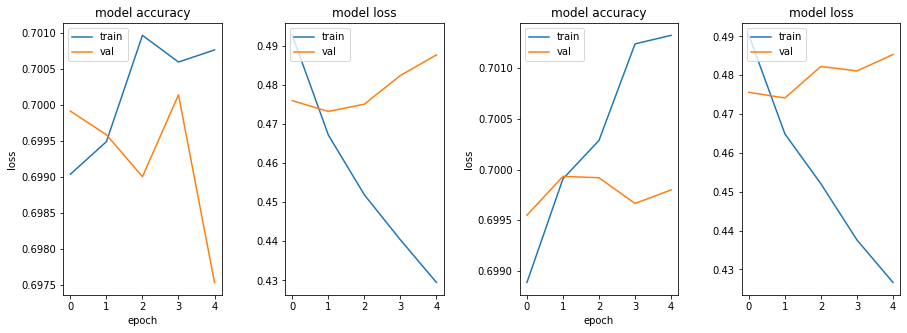

In [ ]:
train()